In [11]:
import black
import pandas as pd
import glob
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pycountry

from collections import Counter
from geopy.geocoders import Nominatim
from pylab import rcParams
from pyvis.network import Network
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
country_codes = [
    "us",
    "gb",
    "ad",
    "ar",
    "au",
    "at",
    "by",
    "be",
    "bo",
    "br",
    "bg",
    "ca",
    "cl",
    "co",
    "cr",
    "cy",
    "cz",
    "dk",
    "do",
    "ec",
    "eg",
    "sv",
    "ee",
    "fi",
    "fr",
    "de",
    "gr",
    "gt",
    "hn",
    "hk",
    "hu",
    "is",
    "id",
    "ie",
    "il",
    "jp",
    "kz",
    "lv",
    "lt",
    "lu",
    "my",
    "mt",
    "mx",
    "ma",
    "nl",
    "nz",
    "ni",
    "ng",
    "no",
    "pk",
    "pa",
    "py",
    "pe",
    "ph",
    "pl",
    "pt",
    "ro",
    "ru",
    "sa",
    "sg",
    "sk",
    "za",
    "kr",
    "es",
    "se",
    "ch",
    "tw",
    "th",
    "tr",
    "ua",
    "ae",
    "uy",
    "ve",
    "vn",
]

# Confusion matrix

To be able to compare countries, we need to come up with a way of comparing the list of songs we obtained from Spofity's charts. For this, we will use *cosine similarity*

In [6]:
country_songs = dict.fromkeys(country_codes)
for country_code in country_codes:
    df_country = pd.read_csv(f"data/songLists/{country_code}.csv")
    df_country["Song and Artist"] = df_country["Artist"] + " " + df_country["Song"]
    country_songs[country_code] = Counter(df_country["Song and Artist"].values.tolist())

In [4]:
# Taken from https://stackoverflow.com/a/14720386
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [9]:
print(counter_cosine_similarity(country_songs["us"], country_songs["th"]))

0.17786595999416813


In [12]:
country_confusion_matrix = np.zeros(shape=(len(country_codes), len(country_codes)))

for index, country_code in enumerate(country_codes):
    for index_b, country_code_b in enumerate(country_codes):
        cosine_similarity = counter_cosine_similarity(
            country_songs[country_code], country_songs[country_code_b]
        )
        country_confusion_matrix[index, index_b] = cosine_similarity

In [13]:
print(country_confusion_matrix)

[[1.         0.47472769 0.16236621 ... 0.11618721 0.11386139 0.17838427]
 [0.47472769 1.         0.19154993 ... 0.08747532 0.07333998 0.15124031]
 [0.16236621 0.19154993 1.         ... 0.25396946 0.04445742 0.0589936 ]
 ...
 [0.11618721 0.08747532 0.25396946 ... 1.         0.24230495 0.04595123]
 [0.11386139 0.07333998 0.04445742 ... 0.24230495 1.         0.11014985]
 [0.17838427 0.15124031 0.0589936  ... 0.04595123 0.11014985 1.        ]]


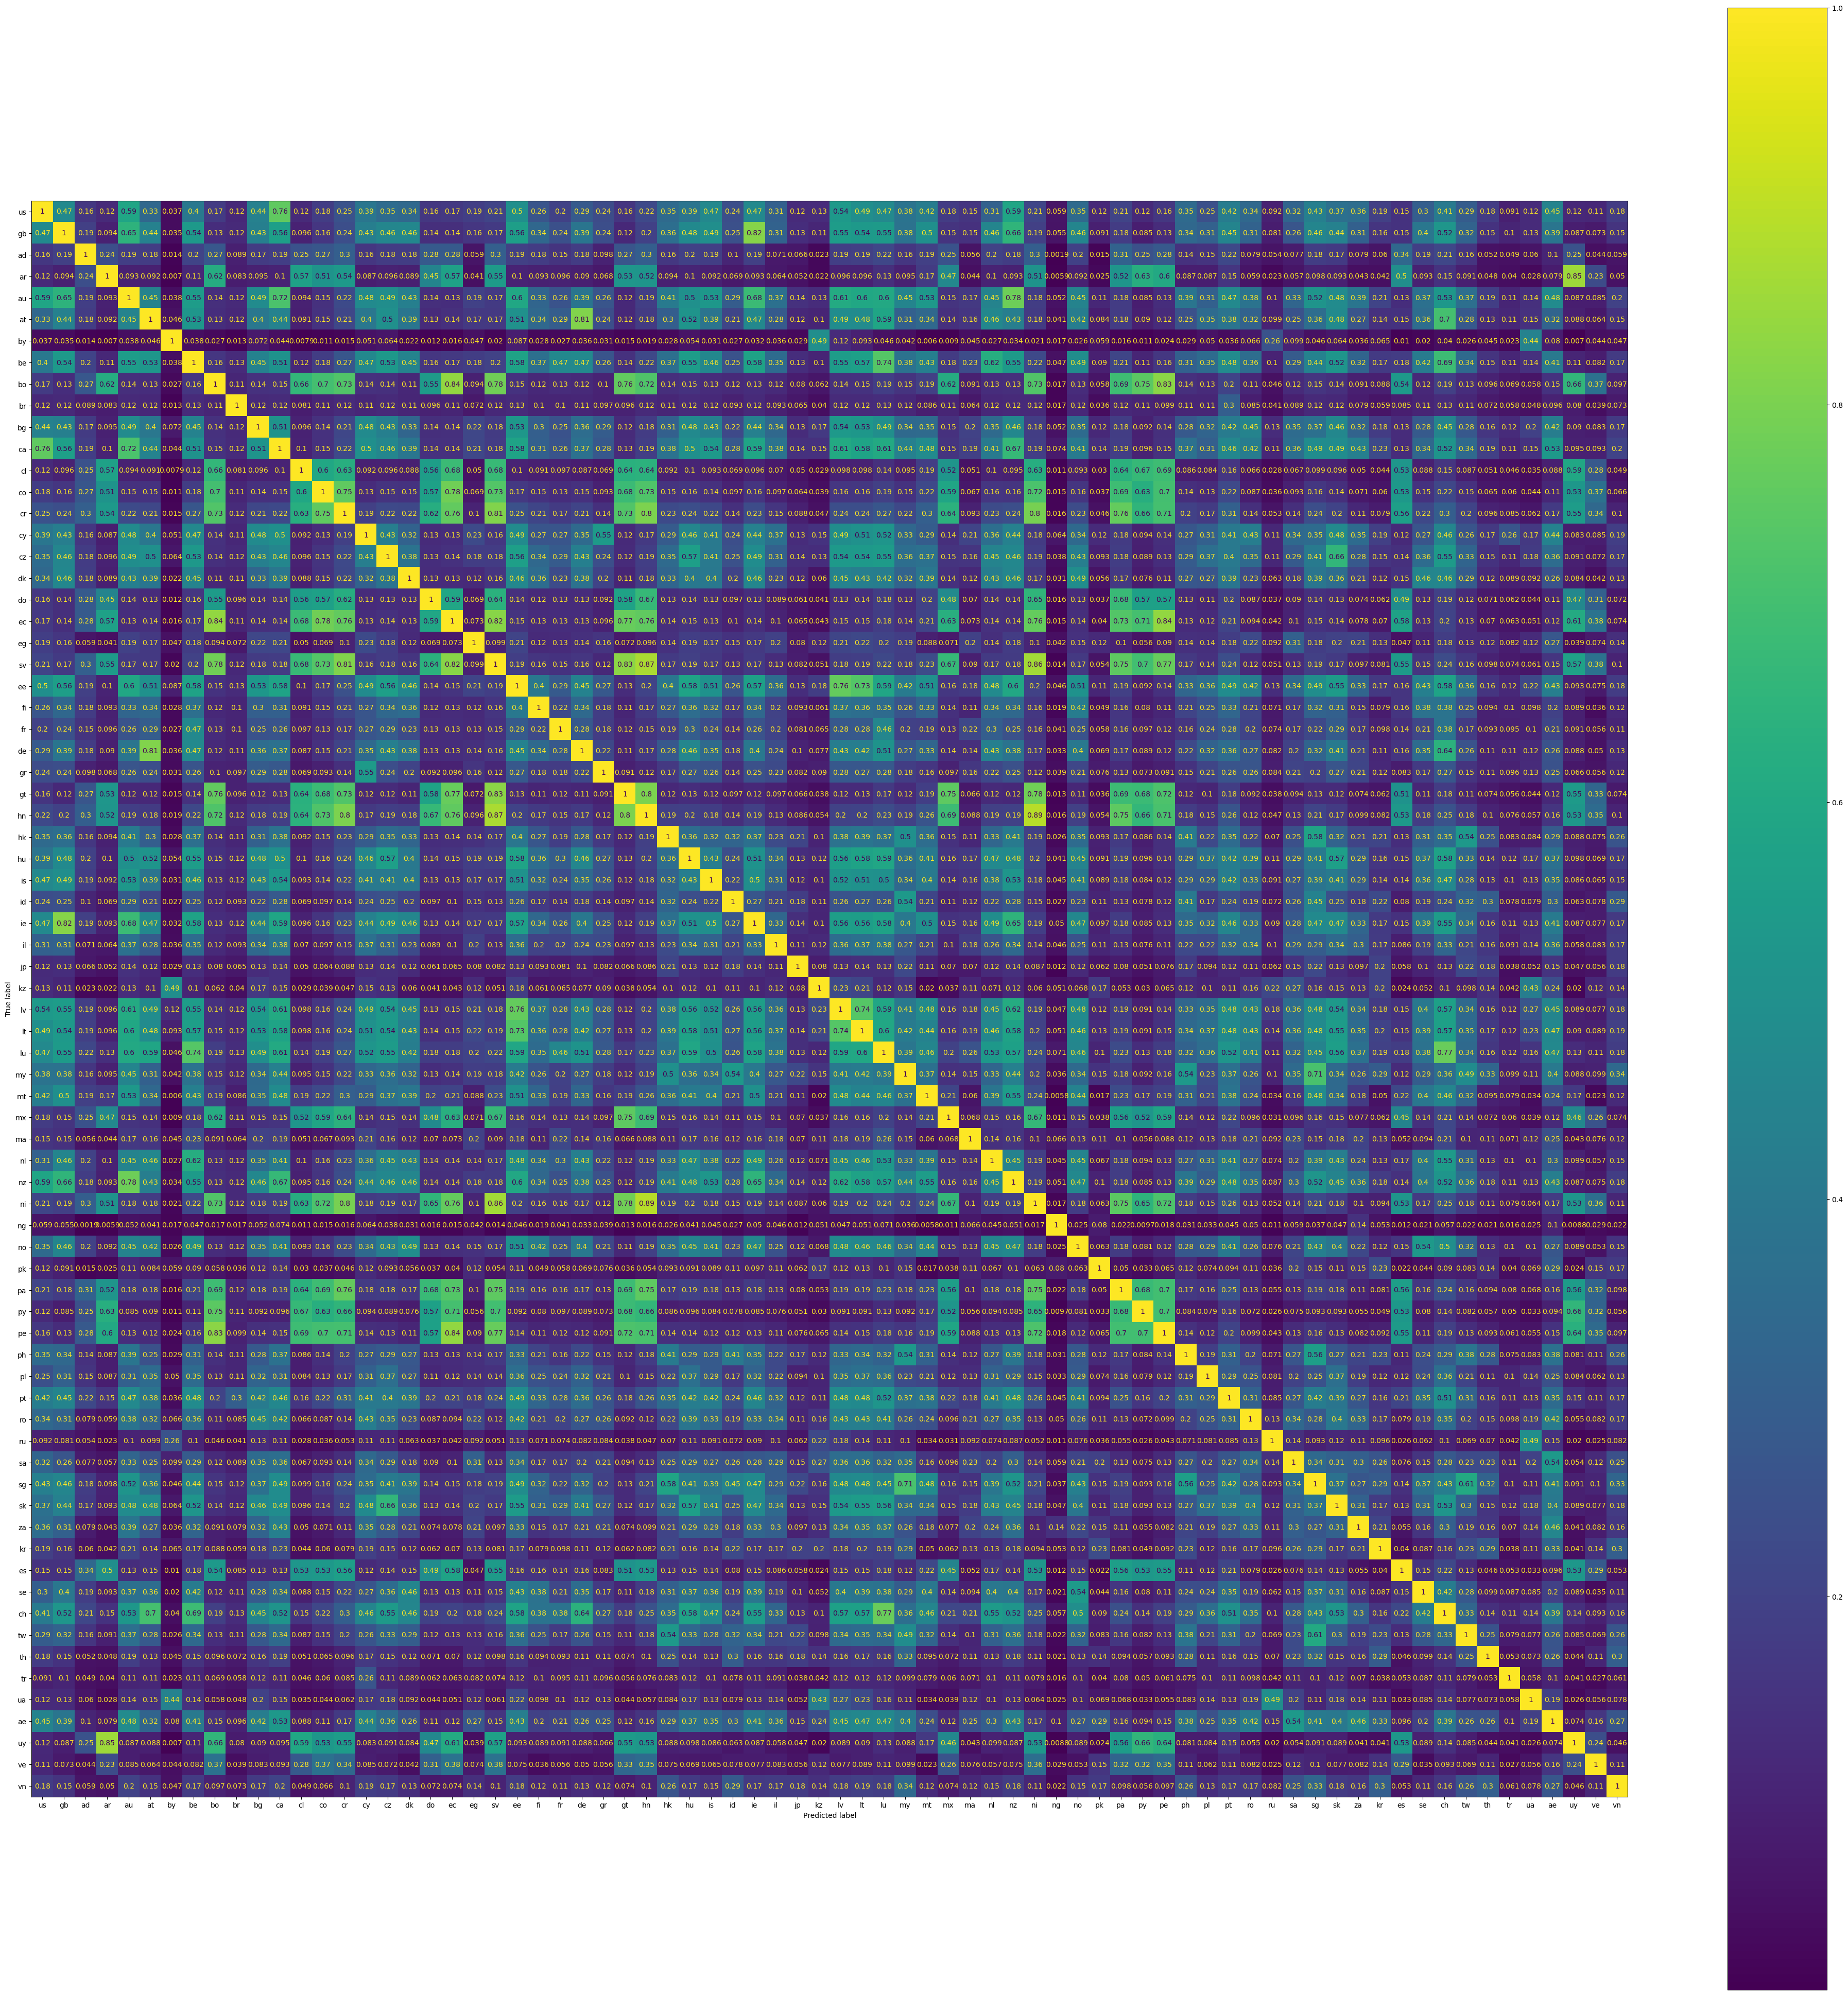

<Figure size 7680x5760 with 0 Axes>

In [16]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=country_confusion_matrix, display_labels=np.asarray(country_codes)
)
fig, ax = plt.subplots(figsize=(50,50))
plt.figure(dpi=1200)
disp.plot(ax=ax)

# Analysis

## Which country is the most ✨*unique*✨?

We have a matrix with cosine similarity scores for each country against every other country (twice). This means that each row contains all of the scores for 1 country. If we add these up, we will have an overall score for that country's similarity with every other country

In [18]:
# Calculate overall similarity score for each country
country_total_scores = []
for country_score in country_confusion_matrix:
  country_total_scores.append(sum(country_score))

# Get the indices of the highest and lowest scores, in order
least_similar_indices = np.argsort(country_total_scores)[:10]
most_similar_indices = np.flip(np.argsort(country_total_scores)[-10:])

In [20]:
print("Here are the 10 countries least similar to other countries")
print("------------------------")
for i in least_similar_indices:
    print(
        f"{pycountry.countries.get(alpha_2=country_codes[i]).name}: {country_total_scores[i]}"
    )

print("\nAnd here are the 10 countries that are the most similar to others")
print("------------------------")
for i in most_similar_indices:
    print(
        f"{pycountry.countries.get(alpha_2=country_codes[i]).name}: {country_total_scores[i]}"
    )

Here are the 10 countries least similar to other countries
------------------------
Nigeria: 3.6039266777259096
Belarus: 4.735577702983237
Türkiye: 7.070655141352947
Russian Federation: 7.312944142885964
Pakistan: 7.431479712976649
Brazil: 8.313163525943766
Japan: 8.885634142425557
Kazakhstan: 9.109260412325401
Ukraine: 9.675000109865735
Morocco: 10.406826956123117

And here are the 10 countries that are the most similar to others
------------------------
Luxembourg: 25.81615519975898
Switzerland: 25.095692523440047
Estonia: 25.08529712289311
Latvia: 25.002533983758312
Lithuania: 24.915797365439733
Australia: 24.513697898658
Canada: 24.441074395258408
Belgium: 24.371917946518998
New Zealand: 24.008219290659536
Ireland: 23.52127041271086


### Plotting

Because looking at a list is boring, we'll plot these scores onto a map

In [21]:
# Convert the list of countries to three-letter ISO codes
country_codes_alpha_3 = [
  pycountry.countries.get(alpha_2=item).alpha_3 for item in country_codes
]

In [23]:
fig = px.choropleth(
  locations=country_codes_alpha_3,
  color=country_total_scores
)
fig.update(layout_height=900, layout_width=1600)
fig.show()

## Which pairs of countries are the most similar?
Essentially, which country pair obtained the highest score?

In [24]:
# k is the number of top pairs we want to get
# A negative k value is used to get the bottom pairs
def get_matrix_indices(matrix, k):
  # Each country comparison is done twice (except a country to itself)
  # As such, we need to double the number of elements we look at
  k = k * 2
  
  # argsort sorts from smallest to biggest
  # If we want to look at the best scores, we need to flip the indices
  indices = (
    np.argsort(matrix.ravel()) if k > 0 else np.flip(np.argsort(matrix.ravel()))
  )

  # k's sign determines whether we're looking at the first or last elements
  # The best scores are the countries compared to themselves, with a score of 1
  # As such, for the best scores, we also need to look at the len(countries)
  range_to_use = k if k > 0 else abs(k) + len(country_codes)

  # np.flip flips the list so scores are ordered logically
  # [-1:-20:-2] slice looks at the 10 last elements of the array
  # The step of -2 avoids duplicate values (as every country is compared twice to each other)
  return np.flip(
    np.array(np.unravel_index(indices, matrix.shape))[:, range(range_to_use)]
    .transpose()
    .tolist()[-1:-20:-2]
  )

In [25]:
least_similar_countries_indices = get_matrix_indices(country_confusion_matrix, 10)
most_similar_countries_indices = get_matrix_indices(country_confusion_matrix, -10)

In [26]:
print("The countries that are most similar")
print("------------------------")
for i in most_similar_countries_indices:
    country_1_name = pycountry.countries.get(alpha_2=country_codes[i[0]]).name
    country_2_name = pycountry.countries.get(alpha_2=country_codes[i[1]]).name
    print(
        f"{country_1_name} and {country_2_name}: {country_confusion_matrix[i[0]][i[1]]}"
    )
    
print("\nThe countries that are least similar")
print("------------------------")
for i in least_similar_countries_indices:
    country_1_name = pycountry.countries.get(alpha_2=country_codes[i[0]]).name
    country_2_name = pycountry.countries.get(alpha_2=country_codes[i[1]]).name
    print(
        f"{country_1_name} and {country_2_name}: {country_confusion_matrix[i[0]][i[1]]}"
    )
    

The countries that are most similar
------------------------
Nicaragua and Honduras: 0.8929342015635893
Honduras and El Salvador: 0.8748772718956946
Nicaragua and El Salvador: 0.8626141407198888
Uruguay and Argentina: 0.8544371145970499
Bolivia, Plurinational State of and Ecuador: 0.8382642998027613
Ecuador and Peru: 0.8362889785965351
El Salvador and Guatemala: 0.8274177830269477
Bolivia, Plurinational State of and Peru: 0.8255044782863804
Ecuador and El Salvador: 0.8216752756317673
Ireland and United Kingdom: 0.8199838276831678

The countries that are least similar
------------------------
Andorra and Nigeria: 0.0019011956576832029
Malta and Nigeria: 0.005843059572604036
Nigeria and Argentina: 0.005866338786600321
Belarus and Malta: 0.005958318397328216
Belarus and Uruguay: 0.0069721115537848604
Argentina and Belarus: 0.00697906628025595
Chile and Belarus: 0.007944424529770955
Nigeria and Uruguay: 0.008790739360403173
Belarus and Mexico: 0.008955228313769725
Nigeria and Paraguay: 0.0

### Plotting

Again, looking at a list is boring. Because plotting 10 pairs of countries can be a bit confusing, I will instead plot a *social network*. We'll make a directed graph, where each edge represents a relationship where country A has the highest cosine similarity score with country B

In [27]:
rows_list = []
for index, country in enumerate(country_codes_alpha_3):
    country_b = country_codes_alpha_3[
        np.argsort(country_confusion_matrix[index], axis=0)[-2]
    ]
    dict_to_append = {"Country_A": country, "Country_B": country_b}
    rows_list.append(dict_to_append)
    
df_country_buddies = pd.DataFrame(rows_list)
df_country_buddies

Country_A Country_B
0        USA       CAN
1        GBR       IRL
2        AND       ESP
3        ARG       URY
4        AUS       NZL
..       ...       ...
69       UKR       RUS
70       ARE       SAU
71       URY       ARG
72       VEN       ECU
73       VNM       MYS

[74 rows x 2 columns]

In [28]:
# Make a dictionary where we will store the coordinates per ISO country code
geolocator = Nominatim(user_agent="spotify_country_comparison")
country_coordinates = {}

In [29]:
# Fill in the dictionary
for country_code in country_codes_alpha_3:
  # We need to pass the code to geopy/OSM because the US has cities called Israel and Germany
  # OSM only accepts ISO's alpha-2 format, so we need to convert it first
  country_code_alpha_2 = country_codes[country_codes_alpha_3.index(country_code)]

  # I was having some issues with names with commas (e.g. Korea, Republic of) timing out
  # So we strip everything after the comma
  country_name = pycountry.countries.get(alpha_3=country_code).name.split(",")[0]
  
  # Retrieve coordinates from OSM through Geopy
  location = geolocator.geocode(
    country_name,
    country_codes=country_code_alpha_2,
  )
  country_coordinates[country_code] = location

In [30]:
# Hong Kong has to be done manually, as the method above returns null
# This is because OSM sets its country code to CN, so asking it to retrieve a location in HK doesn't work
# Not setting a code, or setting the code to be CN, works
# Strangely enough, it also works with a nonsensical code of 3 letters (e.g. LMM), which I don't believe it's the best way to handle erroneous input
country_coordinates["HKG"] = geolocator.geocode("Hong Kong")

In [31]:
print(country_coordinates)

{'USA': Location(United States, (39.7837304, -100.445882, 0.0)), 'GBR': Location(United Kingdom, (54.7023545, -3.2765753, 0.0)), 'AND': Location(Andorra, (42.5407167, 1.5732033, 0.0)), 'ARG': Location(Argentina, (-34.9964963, -64.9672817, 0.0)), 'AUS': Location(Australia, (-24.7761086, 134.755, 0.0)), 'AUT': Location(Österreich, (47.59397, 14.12456, 0.0)), 'BLR': Location(Беларусь, (53.4250605, 27.6971358, 0.0)), 'BEL': Location(België / Belgique / Belgien, (50.6402809, 4.6667145, 0.0)), 'BOL': Location(Bolivia, (-17.0568696, -64.9912286, 0.0)), 'BRA': Location(Brasil, (-10.3333333, -53.2, 0.0)), 'BGR': Location(България, (42.6073975, 25.4856617, 0.0)), 'CAN': Location(Canada, (61.0666922, -107.991707, 0.0)), 'CHL': Location(Chile, (-31.7613365, -71.3187697, 0.0)), 'COL': Location(Colombia, (4.099917, -72.9088133, 0.0)), 'CRI': Location(Costa Rica, (9.536456900000001, -84.17566257468567, 0.0)), 'CYP': Location(Κύπρος, Κύπρος - Kıbrıs, (34.9174159, 32.889902651331866, 0.0)), 'CZE': Loca

In [33]:
# Based on: https://community.plotly.com/t/plotly-arrow-in-scattergeo-with-text-on-the-line/34060

# Create base figure
fig = go.Figure()

# Make this a world map, add hover markers for countries
# We make them invisible because they don't quite align with the coordinates
# I could make this coordinate-based, but it was the first time I was using a world map on Plotly
# So I didn't quite realise until I ran into the arrow problem
fig.add_trace(
    go.Scattergeo(
        locationmode="ISO-3",
        locations=df_country_buddies["Country_A"],
        hoverinfo="text",
        text=df_country_buddies["Country_A"],
        mode="markers",
        marker=dict(
            size=4,
            color="rgba(255, 0, 0, 0)",
            line=dict(width=3, color="rgba(68, 68, 68, 0)"),
        ),
    )
)

# Show borders, lower resolution for better performance
fig.update_geos(
    resolution=110,
    showcountries=True,
    scope="world"
)

# Make lines between countries
for index, row in df_country_buddies.iterrows():
    fig.add_trace(
        go.Scattergeo(
            lat=[
                country_coordinates[row["Country_A"]].latitude,
                country_coordinates[row["Country_B"]].latitude,
            ],
            lon=[
                country_coordinates[row["Country_A"]].longitude,
                country_coordinates[row["Country_B"]].longitude,
            ],
            mode="lines",
            line=dict(width=1, color="blue"),
            hovertext=row["Country_A"] + " --> " + row["Country_B"]
        )
    )

# Arrow-heads solution from the link above
l = 0.8
width = 0.045
for index, row in df_country_buddies.iterrows():
    A=np.array(
        [
            country_coordinates[row["Country_A"]].longitude,
            country_coordinates[row["Country_A"]].latitude,
        ]
    )
    B=np.array(
        [
            country_coordinates[row["Country_B"]].longitude,
            country_coordinates[row["Country_B"]].latitude,
        ]
    )
    v = B - A
    w = v / np.linalg.norm(v)
    u = np.array([-w[1], w[0]]) * 10
    
    P = B - l*w
    S = P - width*u
    T = P + width*u
    
    fig.add_trace(
        go.Scattergeo(
            lon = [S[0], T[0], B[0], S[0]], 
            lat =[S[1], T[1], B[1], S[1]], 
            mode='lines', 
            fill='toself', 
            fillcolor='rgba(0, 0, 255, 0.5)', 
            line_color='rgba(0, 0, 255, 0.5)',
            hoverinfo="skip"
        )
    )

fig.update(layout_showlegend=False, layout_height=900, layout_width=1600)
fig.show()

This is a bit difficult to read. Let's graph it in a more conventional social network graph

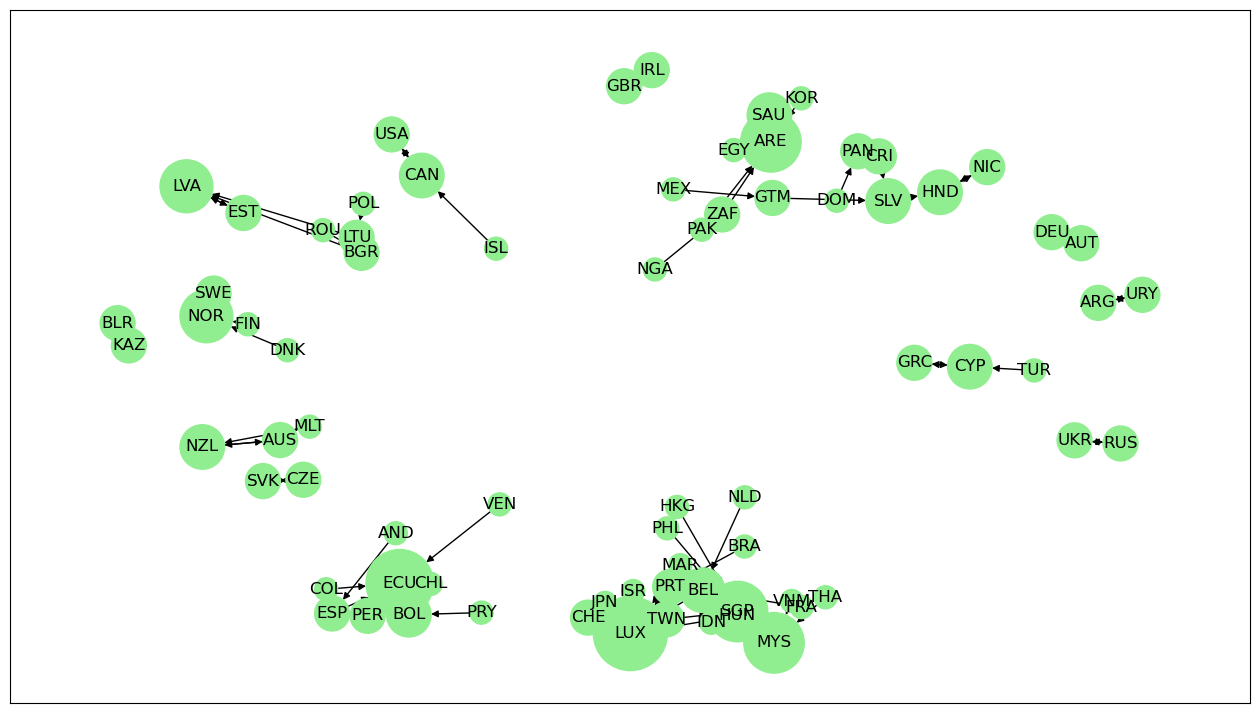

In [39]:
rcParams["figure.figsize"] = 16, 9
G = nx.DiGraph()
for index, row in df_country_buddies.iterrows():
  G.add_edge(row["Country_A"], row["Country_B"])

d = dict(G.degree)
pos = nx.spring_layout(G, scale=3, k=1.85 / np.sqrt(G.order()))
nx.draw_networkx(
  G,
  pos,
  with_labels=True,
  node_color="lightgreen",
  node_size=[d[k] ** 1.2 * 275 for k in d],
)

In [40]:
print(d)

{'USA': 2, 'CAN': 3, 'GBR': 2, 'IRL': 2, 'AND': 1, 'ESP': 2, 'ARG': 2, 'URY': 2, 'AUS': 2, 'NZL': 3, 'AUT': 2, 'DEU': 2, 'BLR': 2, 'KAZ': 2, 'BEL': 3, 'LUX': 7, 'BOL': 3, 'ECU': 6, 'BRA': 1, 'PRT': 2, 'BGR': 2, 'LVA': 4, 'CHL': 1, 'PER': 2, 'COL': 1, 'CRI': 2, 'SLV': 3, 'CYP': 3, 'GRC': 2, 'CZE': 2, 'SVK': 2, 'DNK': 1, 'NOR': 4, 'DOM': 1, 'PAN': 2, 'EGY': 1, 'SAU': 3, 'HND': 3, 'EST': 2, 'FIN': 1, 'FRA': 1, 'GTM': 2, 'NIC': 2, 'HKG': 1, 'SGP': 5, 'HUN': 1, 'ISL': 1, 'IDN': 1, 'MYS': 5, 'ISR': 1, 'JPN': 1, 'TWN': 2, 'LTU': 2, 'CHE': 2, 'MLT': 1, 'MEX': 1, 'MAR': 1, 'NLD': 1, 'NGA': 1, 'ZAF': 2, 'SWE': 2, 'PAK': 1, 'ARE': 5, 'PRY': 1, 'PHL': 1, 'POL': 1, 'ROU': 1, 'RUS': 2, 'UKR': 2, 'KOR': 1, 'THA': 1, 'TUR': 1, 'VEN': 1, 'VNM': 1}


In [42]:
# Originally planned to make the graph with pyvis because it's prettier
# However, arrows for nodes that are reciprocal (e.g., IRL and GBR) don't work
# Only one shows and I can't find why
net = Network(notebook=True)
nx.set_node_attributes(G, {k: v * 10 for k, v in d.items()}, "size")
net.from_nx(G)
net.show_buttons()
net.save_graph("CountryNetwork.html")